Extracted features saved to test_features.txt


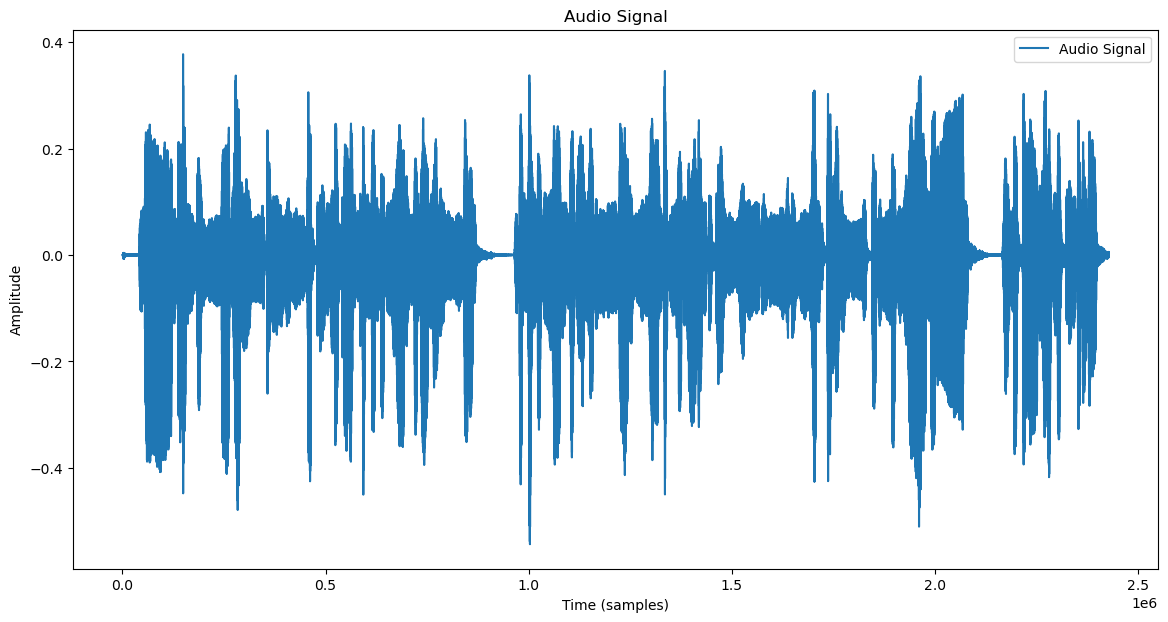

In [1]:
import os
import librosa
import numpy as np
from sklearn.preprocessing import StandardScaler

def extract_features(file_path):
    if not os.path.exists(file_path):
        print(f"File {file_path} does not exist.")
        return None, None, None
    try:
        y, sr = librosa.load(file_path, sr=None)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        scaler = StandardScaler()
        mfccs = scaler.fit_transform(mfccs.T).T  # Normalisasi fitur
        return mfccs, y, sr
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None, None, None

# Path file audio uji
test_audio_path = 'test.opus'

# Ekstraksi fitur dari audio uji
test_features, test_signal, sr = extract_features(test_audio_path)

# Menyimpan fitur yang diekstraksi ke dalam file teks
file_path = "test_features.txt"
np.savetxt(file_path, test_features, delimiter=',')
print(f"Extracted features saved to {file_path}")

# Visualisasi sinyal audio uji
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(test_signal, label='Audio Signal')
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.title('Audio Signal')
plt.legend(loc='upper right')
plt.show()


In [2]:
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
import pickle
import pandas as pd

def calculate_dtw_distance(feature1, feature2):
    distance, path = fastdtw(feature1.T, feature2.T, dist=euclidean)
    return distance, path

def load_model(file_path):
    if not os.path.exists(file_path):
        print(f"Model file {file_path} does not exist.")
        return None
    try:
        with open(file_path, 'rb') as f:
            model = pickle.load(f)
        return [np.array(features) for features in model]
    except Exception as e:
        print(f"Error loading model {file_path}: {e}")
        return None

def detect_tajweed(test_audio_path, models_folder, segment_length=5):
    test_features, test_signal, sr = extract_features(test_audio_path)
    if test_features is None or test_signal is None or sr is None:
        print("Error extracting features from test audio.")
        return [], None, None, None

    segment_length_samples = segment_length * sr
    num_segments = len(test_signal) // segment_length_samples
    segment_results = []

    models = {tajweed.split('_model')[0]: load_model(os.path.join(models_folder, tajweed))
              for tajweed in os.listdir(models_folder) if tajweed.endswith('_model.pkl')}

    for i in range(num_segments):
        start = i * segment_length_samples
        end = start + segment_length_samples
        segment = test_signal[start:end]
        segment_mfcc = librosa.feature.mfcc(y=segment, sr=sr, n_mfcc=13)
        scaler = StandardScaler()
        segment_mfcc = scaler.fit_transform(segment_mfcc.T).T  # Normalisasi fitur
        best_similarity = -np.inf
        best_tajweed = None

        for tajweed, tajweed_features in models.items():
            if tajweed_features is None:
                continue

            distances = [calculate_dtw_distance(train_feature, segment_mfcc)[0] for train_feature in tajweed_features]
            min_distance = min(distances)
            max_distance = max(distances)  # Menghitung nilai maksimum dari distances

            if max_distance == 0:
                similarity = 0  # Menghindari pembagian oleh nol
            else:
                similarity = max(0, 100 - (min_distance / max_distance * 100))  # Hitung similarity dalam persen

            print(f"Segment {i}, Tajweed {tajweed}, Similarity: {similarity:.2f}%")
            if similarity > best_similarity:
                best_similarity = similarity
                best_tajweed = tajweed

        segment_results.append((i, best_tajweed, best_similarity))

    print("Pattern detection completed.")
    return segment_results, test_signal, sr, segment_length_samples

# Path folder tempat model-model Tajweed disimpan
models_folder = 'models'

# Deteksi Tajweed dalam audio uji
segment_results, test_signal, sr, segment_length_samples = detect_tajweed(test_audio_path, models_folder)

# Menyimpan hasil deteksi dalam DataFrame
results_df = pd.DataFrame(segment_results, columns=['Segment', 'Tajweed', 'Similarity'])
print(results_df)


Segment 0, Tajweed idgham_bighunnah, Similarity: 11.88%
Segment 0, Tajweed idgham_bilaghunnah, Similarity: 14.35%
Segment 0, Tajweed idgham_mim, Similarity: 8.72%
Segment 0, Tajweed idgham_musyaddadah, Similarity: 10.89%
Segment 0, Tajweed ikhfa, Similarity: 13.22%
Segment 0, Tajweed ikhfa_syafawi, Similarity: 13.26%
Segment 0, Tajweed iqlab, Similarity: 10.19%
Segment 0, Tajweed izhar, Similarity: 9.38%
Segment 0, Tajweed izhar_syafawi, Similarity: 8.51%
Segment 0, Tajweed mad_asli, Similarity: 13.97%
Segment 0, Tajweed mad_jaiz_munfasil, Similarity: 19.64%
Segment 0, Tajweed mad_wajib, Similarity: 13.62%
Segment 0, Tajweed qalqalah_kubra, Similarity: 9.53%
Segment 0, Tajweed qalqalah_sughra, Similarity: 12.65%
Segment 1, Tajweed idgham_bighunnah, Similarity: 8.77%
Segment 1, Tajweed idgham_bilaghunnah, Similarity: 12.06%
Segment 1, Tajweed idgham_mim, Similarity: 7.02%
Segment 1, Tajweed idgham_musyaddadah, Similarity: 7.98%
Segment 1, Tajweed ikhfa, Similarity: 14.98%
Segment 1, Taj

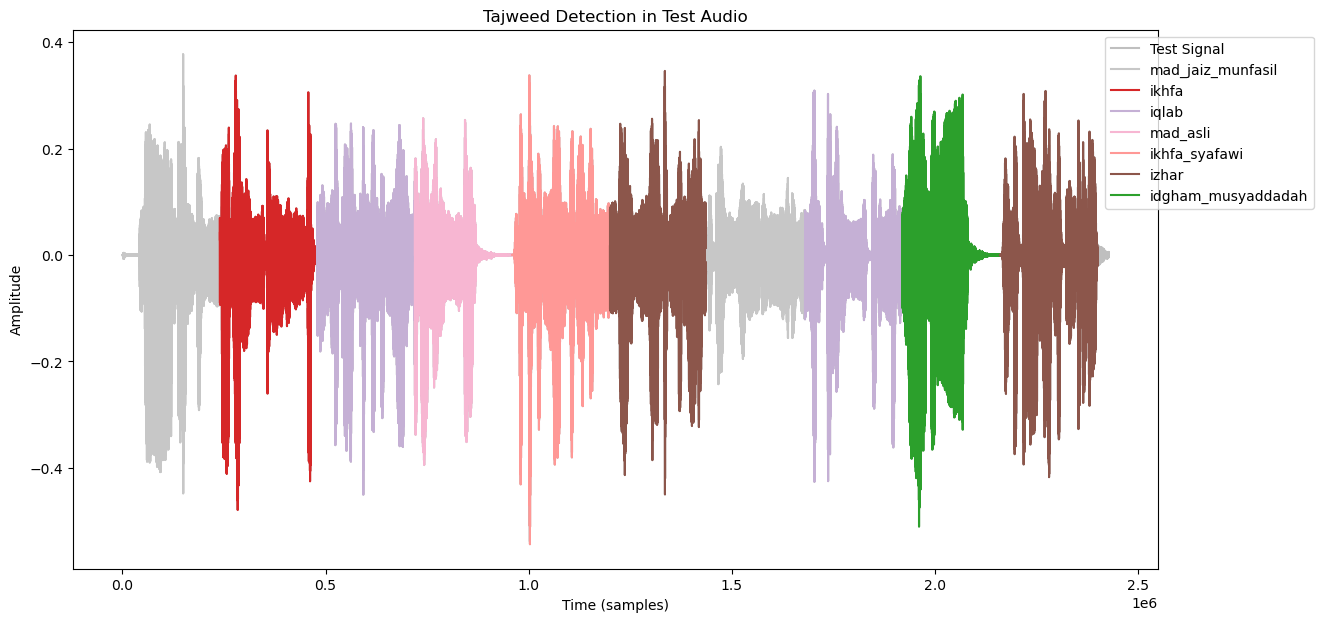

In [3]:
import os
import matplotlib.pyplot as plt

# Path folder tempat model-model Tajweed disimpan
models_folder = 'models'

# Visualisasi deteksi Tajweed dalam audio uji
def plot_detected_tajweed_segments(test_signal, segment_results, sr, segment_length_samples, tajweeds):
    colors = plt.get_cmap('tab20', len(tajweeds))
    plt.figure(figsize=(14, 7))
    plt.plot(test_signal, label='Test Signal', color='gray', alpha=0.5)
    
    legend_labels = set()  # Set untuk menyimpan label legenda unik

    for i, (segment_index, tajweed, _) in enumerate(segment_results):
        start = segment_index * segment_length_samples
        end = start + segment_length_samples
        if tajweed is not None:
            plt.plot(range(start, end), test_signal[start:end], color=colors(tajweeds.index(tajweed)), label=tajweed if tajweed not in legend_labels else "")
            legend_labels.add(tajweed)  # Tambahkan label ke set legenda
    
    plt.xlabel('Time (samples)')
    plt.ylabel('Amplitude')
    plt.title('Tajweed Detection in Test Audio')
    plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
    plt.show()

# Visualisasikan deteksi Tajweed
plot_detected_tajweed_segments(test_signal, segment_results, sr, segment_length_samples, 
                               [tajweed.split('_model')[0] for tajweed in os.listdir(models_folder) if tajweed.endswith('_model.pkl')])
